In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import glob
import seaborn as sns
from  tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from  tensorflow.keras.preprocessing import image

In [2]:
base_path = '/kaggle/input/2022-2-cnu-mlclass2'

train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))

# EDA

In [3]:
train_df.label.value_counts()

cake             1184
pasta            1072
steak            1048
fried_chicken    1034
pizza             963
grilled_eel       951
ramen             881
pork_cutlet       869
janchi_guksu      856
tteokbokki        841
jajangmyeon       833
pork_belly        789
Name: label, dtype: int64

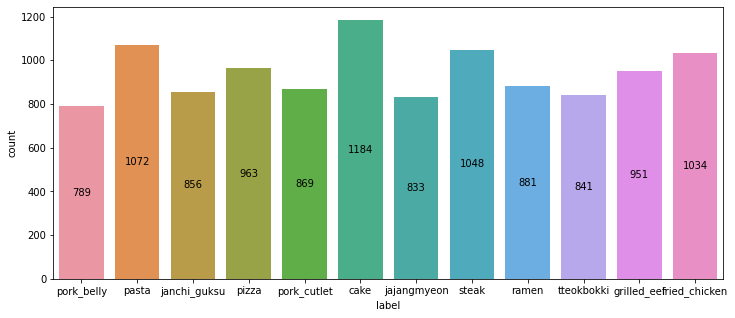

In [4]:
# 데이터 분포

figure = plt.figure(figsize=(12, 5))
ax = figure.add_subplot()
sns.countplot(data=train_df, x='label', ax=ax)

for patch in ax.patches:
    label_x = patch.get_x() + patch.get_width()/2
    label_y = patch.get_y() + patch.get_height()/2
    text_msg = str(int(patch.get_height())) 
    ax.text(label_x, label_y, text_msg, horizontalalignment='center', verticalalignment='center')
    
plt.show()

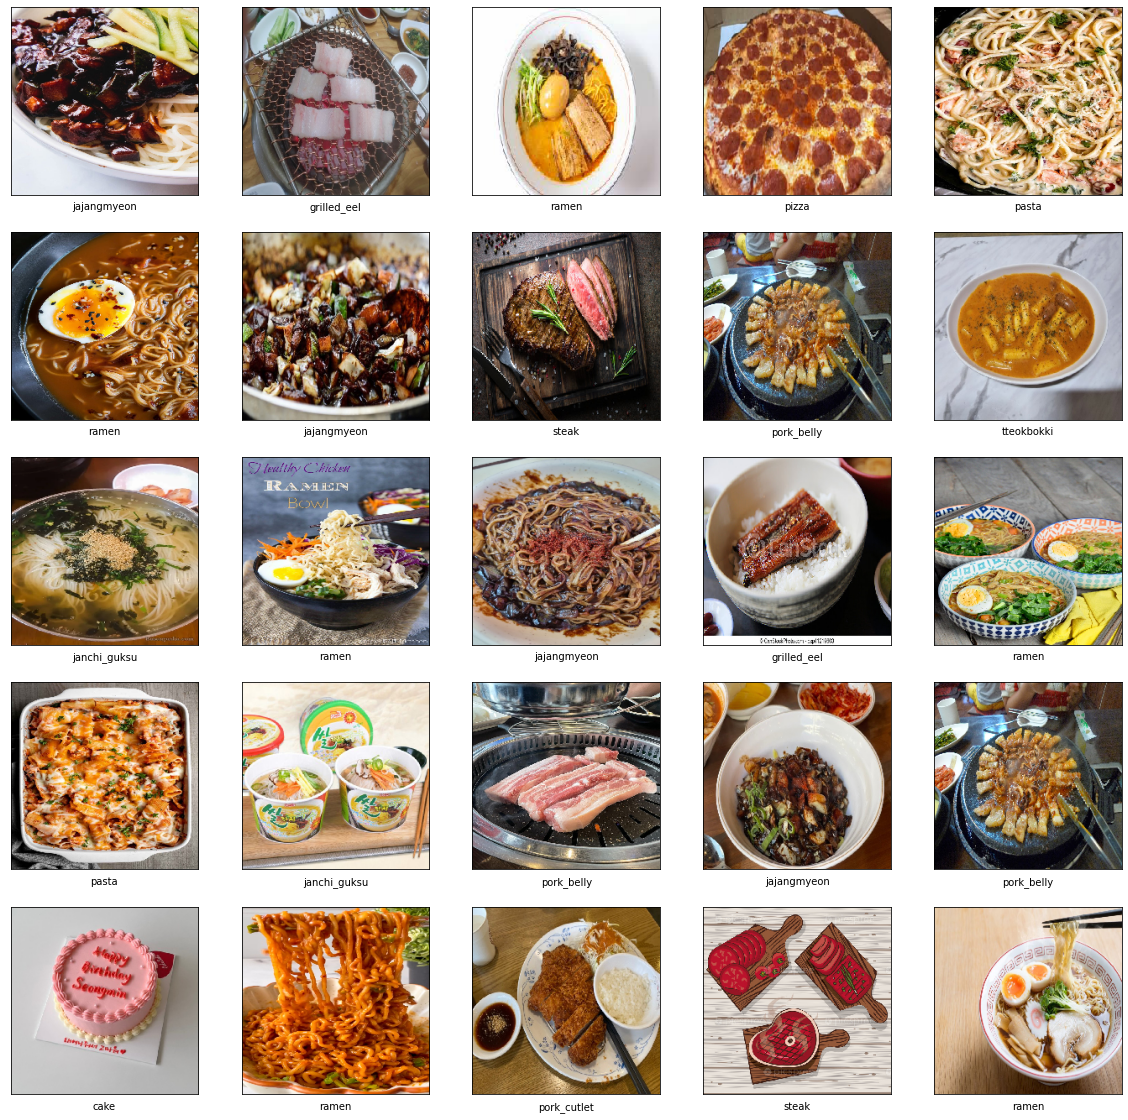

In [5]:
# 이미지 시각화
path = os.path.join(base_path, 'train')

plt.figure(figsize=(20,20))
index = np.random.randint(len(train_df), size=25)
for i in range(25):
    label = train_df['label'][index[i]]
    path_img = train_df['image'][index[i]]
    path_img = os.path.join(path, os.path.join(label, path_img))
    
    img = image.load_img(path_img,target_size=(224,224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()

# 전처리

In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_df, test_size=0.1, stratify=train_df['label'])
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [7]:
cls = lambda x : os.path.join(path, '_'.join(x.split('_')[1:-1])+'/'+x)
train['image'] = train['image'].map(lambda x : cls(x))
train.head(10)

image          label
0  /kaggle/input/2022-2-cnu-mlclass2/train/janchi...   janchi_guksu
1  /kaggle/input/2022-2-cnu-mlclass2/train/cake/n...           cake
2  /kaggle/input/2022-2-cnu-mlclass2/train/pork_b...     pork_belly
3  /kaggle/input/2022-2-cnu-mlclass2/train/pork_b...     pork_belly
4  /kaggle/input/2022-2-cnu-mlclass2/train/jajang...    jajangmyeon
5  /kaggle/input/2022-2-cnu-mlclass2/train/fried_...  fried_chicken
6  /kaggle/input/2022-2-cnu-mlclass2/train/steak/...          steak
7  /kaggle/input/2022-2-cnu-mlclass2/train/pizza/...          pizza
8  /kaggle/input/2022-2-cnu-mlclass2/train/tteokb...     tteokbokki
9  /kaggle/input/2022-2-cnu-mlclass2/train/tteokb...     tteokbokki

In [8]:
valid['image'] = valid['image'].map(lambda x : cls(x))
valid.head(10)

image          label
0  /kaggle/input/2022-2-cnu-mlclass2/train/tteokb...     tteokbokki
1  /kaggle/input/2022-2-cnu-mlclass2/train/grille...    grilled_eel
2  /kaggle/input/2022-2-cnu-mlclass2/train/grille...    grilled_eel
3  /kaggle/input/2022-2-cnu-mlclass2/train/pasta/...          pasta
4  /kaggle/input/2022-2-cnu-mlclass2/train/steak/...          steak
5  /kaggle/input/2022-2-cnu-mlclass2/train/pork_b...     pork_belly
6  /kaggle/input/2022-2-cnu-mlclass2/train/fried_...  fried_chicken
7  /kaggle/input/2022-2-cnu-mlclass2/train/pork_b...     pork_belly
8  /kaggle/input/2022-2-cnu-mlclass2/train/fried_...  fried_chicken
9  /kaggle/input/2022-2-cnu-mlclass2/train/steak/...          steak

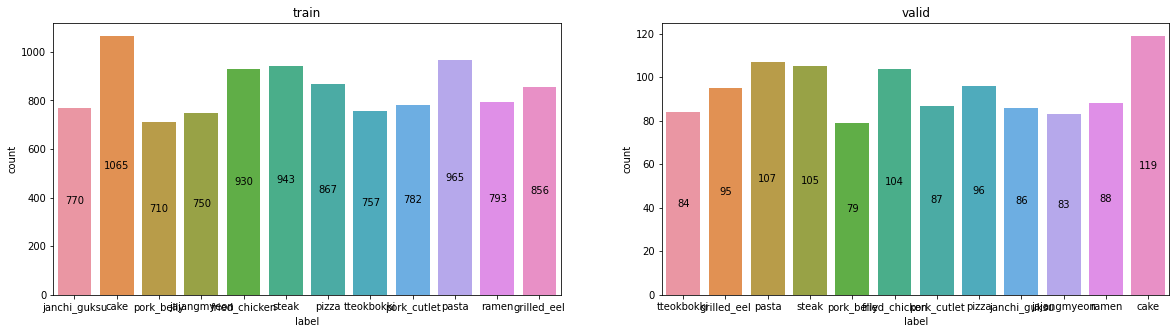

In [9]:
# 분할 후 데이터 분포

figure, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(data=train, x='label', ax=ax[0])
sns.countplot(data=valid, x='label', ax=ax[1])

ax[0].set_title('train')
for patch in ax[0].patches:
    label_x = patch.get_x() + patch.get_width()/2
    label_y = patch.get_y() + patch.get_height()/2
    text_msg = str(int(patch.get_height())) 
    ax[0].text(label_x, label_y, text_msg, horizontalalignment='center', verticalalignment='center')

ax[1].set_title('valid')
for patch in ax[1].patches:
    label_x = patch.get_x() + patch.get_width()/2
    label_y = patch.get_y() + patch.get_height()/2
    text_msg = str(int(patch.get_height())) 
    ax[1].text(label_x, label_y, text_msg, horizontalalignment='center', verticalalignment='center')

plt.show()

In [10]:
# 데이터 증강

height, width, channel = (224, 224, 3)
batch_size = 32
labels = train.label.unique().tolist()

train_datagen= ImageDataGenerator(rescale=1./255,
                              rotation_range=20,
                              width_shift_range=0.05,
                              height_shift_range=0.05,
                              zoom_range=[0.7, 1],
                              horizontal_flip=True,
                              vertical_flip=False,
                              fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(train,
                                                   directory = './train',
                                                   x_col='image',
                                                   y_col='label',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode= 'rgb',
                                                   target_size=(height, width))


valid_datagen = ImageDataGenerator(rescale=1. / 255.)

valid_generator = valid_datagen.flow_from_dataframe(valid,
                                                   directory = './train',
                                                   x_col='image',
                                                   y_col='label',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode= 'rgb',
                                                   target_size=(height, width))

Found 10188 validated image filenames belonging to 12 classes.
Found 1133 validated image filenames belonging to 12 classes.


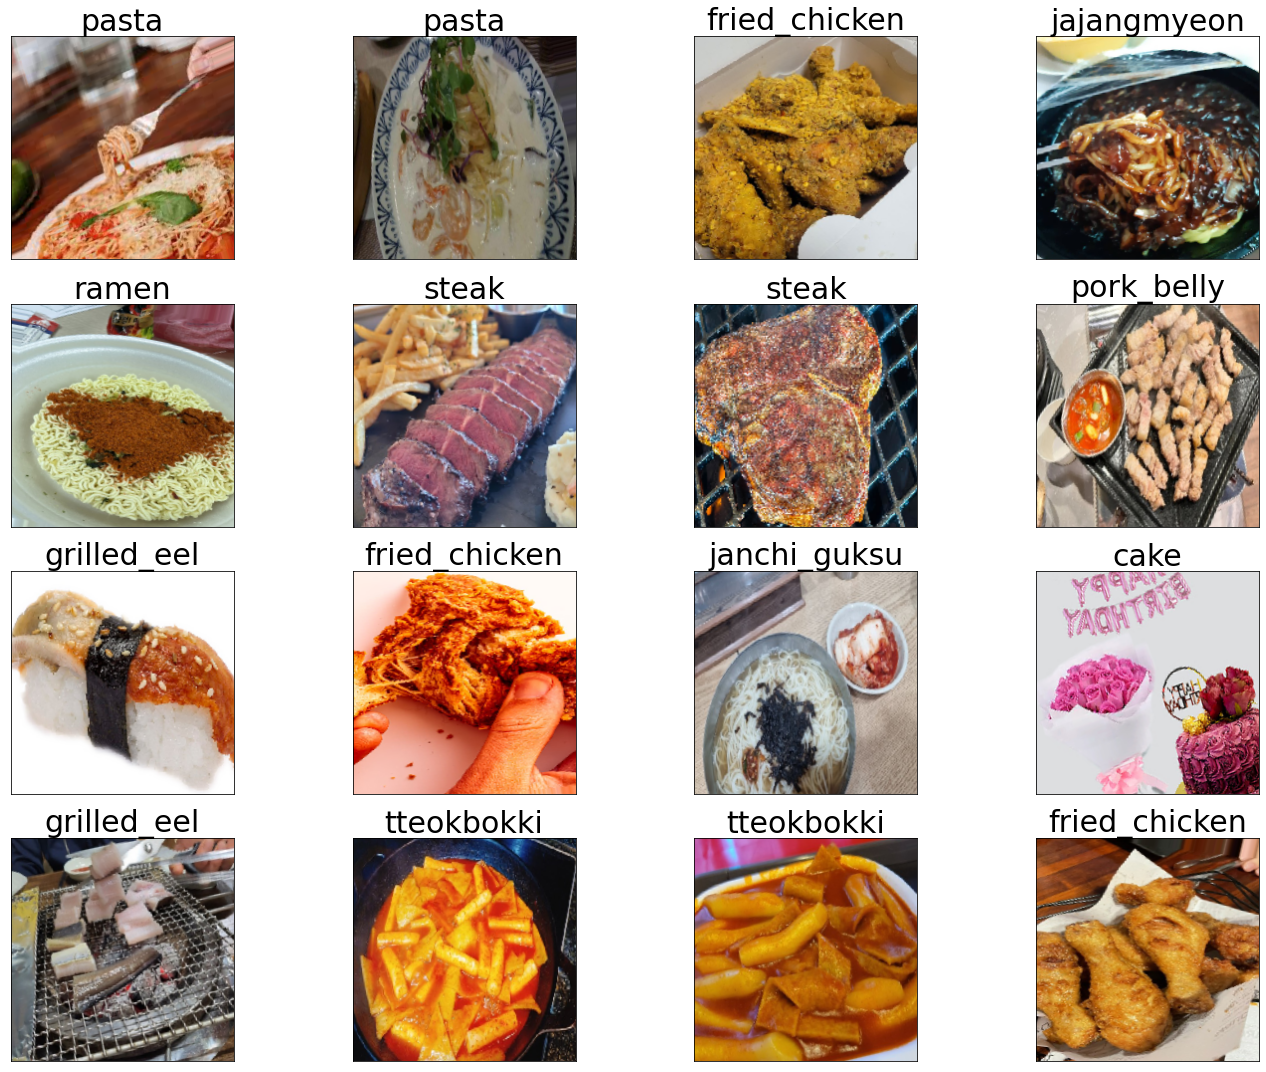

In [11]:
# 데이터 증강 시각화

pred2label={}
for x in train_generator.class_indices.keys():
    pred2label[train_generator.class_indices[x]] = x


plt.figure(figsize=(20,15))
index = np.random.randint(len(train_df), size=batch_size)
x_augs, y_augs = train_generator.next()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_augs[i, :, :, :])
    plt.title(pred2label[np.argmax(y_augs[i, :])], fontsize=30)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.tight_layout()
plt.show()

# 모델 학습

In [12]:
import tensorflow

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Resizing
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=256, kernel_size=3,activation="relu", input_shape=(height, width, channel)))
cnn_model.add(MaxPool2D(pool_size=2, strides=2))
cnn_model.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
cnn_model.add(MaxPool2D(pool_size=2, strides=2))
cnn_model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
cnn_model.add(MaxPool2D(pool_size=2, strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=512, activation="relu"))
cnn_model.add(Dropout(0.15))
cnn_model.add(Dense(units=len(labels), activation="softmax"))

2022-11-15 12:18:40.007623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:18:40.090869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:18:40.091654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:18:40.093837: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
# 모델 확인
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [15]:
# 조기멈춤
stop = EarlyStopping(patience=5)

# 자동 저장
checkpoint = ModelCheckpoint("best_model/model_weights",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1,save_best_only=True)
callbacks = [stop, checkpoint]

# 모델 컴파일
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
# 모델 훈련
cnn_history = cnn_model.fit(train_generator,
                            validation_data=valid_generator,
                            callbacks=callbacks,
                            verbose=2,
                            epochs=20)

# 모델 저장
#cnn_model.save('cnn_model.h5')

2022-11-15 12:18:43.922278: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-15 12:18:46.401482: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


319/319 - 294s - loss: 2.4381 - accuracy: 0.1375 - val_loss: 2.3597 - val_accuracy: 0.1853

Epoch 00001: val_accuracy improved from -inf to 0.18535, saving model to best_model/model_weights
Epoch 2/20
319/319 - 244s - loss: 2.1973 - accuracy: 0.2420 - val_loss: 2.0223 - val_accuracy: 0.3177

Epoch 00002: val_accuracy improved from 0.18535 to 0.31774, saving model to best_model/model_weights
Epoch 3/20
319/319 - 242s - loss: 1.8762 - accuracy: 0.3712 - val_loss: 1.7440 - val_accuracy: 0.4210

Epoch 00003: val_accuracy improved from 0.31774 to 0.42101, saving model to best_model/model_weights
Epoch 4/20
319/319 - 243s - loss: 1.6447 - accuracy: 0.4514 - val_loss: 1.8034 - val_accuracy: 0.4148

Epoch 00004: val_accuracy did not improve from 0.42101
Epoch 5/20
319/319 - 243s - loss: 1.4925 - accuracy: 0.5068 - val_loss: 1.4857 - val_accuracy: 0.5260

Epoch 00005: val_accuracy improved from 0.42101 to 0.52604, saving model to best_model/model_weights
Epoch 6/20
319/319 - 243s - loss: 1.3797

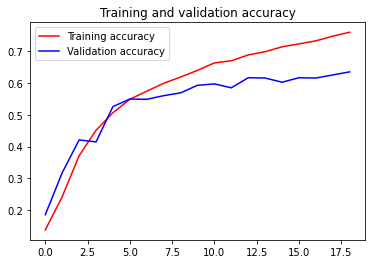

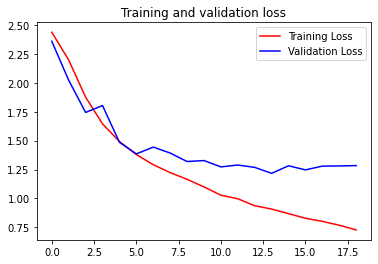

In [17]:
# 정확도와 손실값 확인

acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 테스트

In [18]:
cnn_model.load_weights('./best_model/model_weights')

In [19]:
test_df = pd.read_csv(os.path.join(base_path, "./submission.csv"))
test_df.head(5)

image  label
0  test_1553.jpg    NaN
1  test_2202.jpg    NaN
2  test_1556.jpg    NaN
3   test_660.jpg    NaN
4   test_677.jpg    NaN

In [20]:
batch_size = len(test_df["image"])
height, width, channel = 224, 224, 3

In [21]:
path =  os.path.join(base_path, 'test')

test_image = np.zeros((batch_size, height, width, channel))
print(test_image.shape)
cnt=0
for i in range(len(test_df["image"])):
    path_img = test_df['image'][i]
    img = image.load_img(os.path.join(path,path_img), target_size=(height, width))
    img_tensor = image.img_to_array(img)
    img_tensor = np.array(img_tensor,dtype="float32")

    img_tensor /= 255
    
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    test_image[i] = img_tensor

(2766, 224, 224, 3)


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [22]:
predictions = cnn_model.predict(test_image)

2022-11-15 13:37:53.100667: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1665441792 exceeds 10% of free system memory.
2022-11-15 13:37:55.192438: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1665441792 exceeds 10% of free system memory.


In [23]:
test_df['label'] = [pred2label[np.argmax(pred)] for pred in predictions]
test_df

image          label
0     test_1553.jpg          ramen
1     test_2202.jpg           cake
2     test_1556.jpg    pork_cutlet
3      test_660.jpg          pizza
4      test_677.jpg          ramen
...             ...            ...
2761  test_2189.jpg    grilled_eel
2762   test_223.jpg  fried_chicken
2763   test_303.jpg          pasta
2764  test_1681.jpg   janchi_guksu
2765   test_777.jpg           cake

[2766 rows x 2 columns]

In [24]:
test_df.to_csv('./submission.csv', index=False)